# Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones
## Programación Distribuida sobre Grandes Volúmenes de Datos

Damián Barsotti 

### Facultad de Matemática Astronomía Física y Computación
## Universidad Nacional de Córdoba

<img src="http://program.ar/wp-content/uploads/2018/07/logo-UNC-FAMAF.png" alt="Drawing" style="width:80%;"/>

### Transformer

* Toma un `DataFrame` y devuelven un `DataFrame` transformado.
    - método `transform(<DataFrame>)`
* Ejemplos:
    - Transformador de features
    Un transformador toma Dataframe de entrada y entrega un 
    dataframe de salida, a partir de un metodo `transform`
    
        %%% yuml type=class style=plain format=svg
          [note:Dataframe;Entrada{bg:cornsilk}]->[Transformer;(featurizer)|transform(){bg:orange}]
          [Transformer;(featurizer)|transform(){bg:orange}]->[note:Dataframe; features{bg:cornsilk}]
        %%%

    - Modelo
    Un tranformador tambien puede ser un modelo. no solamente un 
    transformador de features
    
        %%% yuml type=class style=plain format=svg
          [note:Dataframe; features{bg:cornsilk}]->[Transformer;(modelo)|transform(){bg:orange}]
          [Transformer;(modelo)|transform(){bg:orange}]->[note:Dataframe; predicción{bg:cornsilk}]
        %%%


### Estimator

* Encapsula un algoritmo ML.
* Toma un `DataFrame` de entrenamiento y devuelve un `Transformer`
    - método `fit(<DataFrame>)`

      %%% yuml type=class style=plain format=svg
         [note:Dataframe; features;(entrenamiento){bg:cornsilk}]->[Estimator;(algoritmo ML)|fit()]
         [Estimator;(algoritmo ML)|fit(){bg:red}]->[note:Transformer;(modelo){bg:orange}]
      %%%

* Ejemplos:
    - Logistic Regression

Veamos el siguiente ejemplo con un flujo de trabajo ML clásico.

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("06_ml_pipelines").getOrCreate()
sc = spark.sparkContext

### Datos de entrenamiento

In [3]:
training = spark.createDataFrame([
        (0, "a b c d e spark a", 1.0),
        (1, "b d", 0.0),
        (2, "spark f g h", 1.0),
        (3, "hadoop a mapreduce", 0.0)
    ], ["id", "text", "label"])

In [4]:
training.show()

+---+------------------+-----+
| id|              text|label|
+---+------------------+-----+
|  0| a b c d e spark a|  1.0|
|  1|               b d|  0.0|
|  2|       spark f g h|  1.0|
|  3|hadoop a mapreduce|  0.0|
+---+------------------+-----+



### Featurization
#### Tokenizer
Tranforma una linea de texto en bolsa palabras

In [5]:
from pyspark.ml.feature import HashingTF, Tokenizer

# Creo Tokenizer Transformer
tokenizer = Tokenizer(
    inputCol="text",
    outputCol="words")

# Aplico la transformación devolviendo un nuevo dataframe
tokenizerOut = tokenizer.transform(training)

tokenizerOut.show()

+---+------------------+-----+--------------------+
| id|              text|label|               words|
+---+------------------+-----+--------------------+
|  0| a b c d e spark a|  1.0|[a, b, c, d, e, s...|
|  1|               b d|  0.0|              [b, d]|
|  2|       spark f g h|  1.0|    [spark, f, g, h]|
|  3|hadoop a mapreduce|  0.0|[hadoop, a, mapre...|
+---+------------------+-----+--------------------+



### Feature Vector
#### HashingTF
Es un forma de hacer una bolsa de palabra bastante eficiente 
que en lugar de almacenar las palabras almacena el hash

Ademas permite que cada bolsa de palabra tendra un tamaño maximo

##### Bag of Word
Cuando la entrada de algorimo es texto, lo que suele hacer 
un arreglo donde cada posicion del arreglo representa una palabra distinta, y si en el texto aparece una palabra se le suma 1 en 
la posicion correspondiente a la palabra en el arreglo.

Entonces necesito un vector de todas las posibles palabras existentes
en mi texto.

Pero teniendo un hash ya no me importa tanto el tamaño del texto
sino el tamaño de hash, y lo que hace es contar palabras que tengan el 
mismo hash.

In [6]:
# Creo un Term Frecuency Transformer con hash
hashingTF = HashingTF(
    numFeatures=1000,
    inputCol = tokenizer.getOutputCol(), 
    outputCol="features")

# Aplico la transformación al resultado de la transformación previa
hashingTFOut = hashingTF.transform(tokenizerOut)

hashingTFOut.printSchema() 
# Notar tipo de la columna "features"
# El primer elemento de la tupla es el tamaño

root
 |-- id: long (nullable = true)
 |-- text: string (nullable = true)
 |-- label: double (nullable = true)
 |-- words: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



Se Crea una columna nueva de tipo vector, en donde se almacenan 
los valores ditintos de cero, en donde el primer elmento es el 
tamaño total = `10000`. Seguido una lista con las posiciones distintas de 0, y despues otra lista que me dicen cuantas palabras aparacen que tengan el mismo hash en cada posicion.

Otra carcteristica de las bolsa de palabras es que no se sabe el orden en el que aparecen en el texto.

In [7]:
hashingTFOut.show()

+---+------------------+-----+--------------------+--------------------+
| id|              text|label|               words|            features|
+---+------------------+-----+--------------------+--------------------+
|  0| a b c d e spark a|  1.0|[a, b, c, d, e, s...|(1000,[165,286,46...|
|  1|               b d|  0.0|              [b, d]|(1000,[165,890],[...|
|  2|       spark f g h|  1.0|    [spark, f, g, h]|(1000,[286,486,49...|
|  3|hadoop a mapreduce|  0.0|[hadoop, a, mapre...|(1000,[467,585,75...|
+---+------------------+-----+--------------------+--------------------+



### Modelo
#### Creacion

In [8]:
from pyspark.ml.classification import LogisticRegression

# Creo el Estimator
lr = LogisticRegression(
    maxIter=10,
    regParam=0.01)
  
# Entreno el Estimador obteniendo un modelo
model = lr.fit(hashingTFOut)

#### Predicción

In [9]:
# Creo un DF para testearel modelo
test = spark.createDataFrame([
  (4, "spark i j k a"),
  (5, "l m n"),
  (6, "mapreduce spark"),
  (7, "apache hadoop"),
  (8, "spark f j k")
], ["id", "text"])


# Featurizo el test
testTokens = tokenizer.transform(test)

testFeatures = hashingTF.transform(testTokens)

predictions = model.transform(testFeatures)

predictions.select("id", "text", "probability", "prediction").show()

+---+---------------+--------------------+----------+
| id|           text|         probability|prediction|
+---+---------------+--------------------+----------+
|  4|  spark i j k a|[0.41787088770315...|       1.0|
|  5|          l m n|[0.95412623885153...|       0.0|
|  6|mapreduce spark|[0.83657689444953...|       0.0|
|  7|  apache hadoop|[0.98578644499166...|       0.0|
|  8|    spark f j k|[0.25910961733038...|       1.0|
+---+---------------+--------------------+----------+



## Pipelines
---

* Abstracción del flujo de trabajo en ML:

      %%% yuml style=plain scale=80 dir=LR format=svg
        [Featurization]->[Entrenamiento]
        [Entrenamiento]->[Modelo]
        [Modelo]->[Predicción]
        [Modelo]->[Evaluación]
      %%%

* Para su construcción se usan **Transformers** y **Estimators** (llamados Stages)
    - los concatena

* Un pipeline es un **Estimator**
    - método `fit(<DataFramee>)` devuelve un `PipelineModel` (Transformer)
    - `stages` las etapas del pipeline 

In [10]:
from pyspark.ml import Pipeline

# Creo el pipeline con los Transformers y el Estimator
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

# Con fit el pipeline genera los fetures y entrena.
pipModel = pipeline.fit(training)


### Pipeline de entrenamiento

<img     src="https://bitbucket.org/bigdata_famaf/diplodatos_bigdata/raw/b17129f7118b3389b8c7f2f85fd89c6238fe0edd/clases/06_ml_pipelines/ml-Pipeline.png" alt="Drawing" style="width:80%;"/>

### PipelineModel

* El resultado anterior es un modelo (Transformer) que se puede usar para predecir
    - método `transform(<DataFrame>)`
* Usa los mismos Transformers de *featurizacion* que para el entrenamiento
    - ahorra código

In [11]:
# El modelo en el pipeline solo necesita el Raw Test:
# automaticamente aplica los transformadores de features
# y hace predicciones.

predictions = pipModel.transform(test)

predictions.select("id", "text", "probability", "prediction").show()

+---+---------------+--------------------+----------+
| id|           text|         probability|prediction|
+---+---------------+--------------------+----------+
|  4|  spark i j k a|[0.41787088770315...|       1.0|
|  5|          l m n|[0.95412623885153...|       0.0|
|  6|mapreduce spark|[0.83657689444954...|       0.0|
|  7|  apache hadoop|[0.98578644499166...|       0.0|
|  8|    spark f j k|[0.25910961733038...|       1.0|
+---+---------------+--------------------+----------+



### Persistencia

In [12]:
from pyspark.ml import PipelineModel

# El pipeline entrenado se puede guardar
pipModel.write().overwrite().save("../outpus/spark-logistic-regression-model")

# Y cargarlo para la etapa de uso
samePipModel = PipelineModel.load("../outpus/spark-logistic-regression-model")

# Tambien el pipeline sin entrenar
pipeline.write().overwrite().save("../outpus/unfit-lr-model")

In [13]:
!ls ../outpus/spark-logistic-regression-model

metadata  stages


### Ejercicio

Hacer con pipelines uno de los ejemplos de clasificacionde clase anterior. Plotear el resultado.


1. Cargo DataSet

In [14]:
inputFile = "../inputs/ds/people_sex_height_age_weight.json"

people = spark.read.json(inputFile) \
    .select("kgs", "mts", "sex") \
    .repartition(sc.defaultParallelism) \
    .cache()
    
print("Cantidad de filas: {}. Cantidad de particiones: {}.".format(people.count(), people.rdd.getNumPartitions()))

people.sample(False,0.001).show()

Cantidad de filas: 10000. Cantidad de particiones: 20.
+------------------+------------------+---+
|               kgs|               mts|sex|
+------------------+------------------+---+
| 59.30095554158178|  1.55282461831371|  F|
| 54.66081516084203|1.7332577682767587|  F|
| 81.44412109264148|1.8537933285241945|  M|
| 70.06667001846606| 1.684351354365278|  F|
| 97.51848311257145|1.8707762443318086|  M|
|113.36980387828727|1.9516682283010107|  M|
| 81.79141795962448|  1.82723409435759|  M|
| 90.27283594932796|  1.77395239931756|  F|
| 109.1182742470935|1.7470182829244116|  F|
+------------------+------------------+---+



2. Split DataSet

In [15]:
trainDF, testDF = people.randomSplit([0.95, 0.05]) 

print(testDF.count(), trainDF.count())

527 9473


3. VectorAssembler

In [16]:
from pyspark.ml.feature import VectorAssembler

vAssembler = VectorAssembler(
    inputCols=["kgs", "mts"],
    outputCol="features")

4. StringIndexer

In [17]:
from pyspark.ml.feature import StringIndexer

strIndexer = StringIndexer(
  inputCol="sex",
  outputCol="label")

5. PolynomialExpansion

In [18]:
from pyspark.ml.feature import PolynomialExpansion

polyExpansion = PolynomialExpansion( 
    inputCol="features",
    outputCol="features_expansion",
    degree=3) # llenar (ver documentacion)

#### Creacion del `Pipeline`

In [19]:
# Creo el pipeline con los Transformers y el Estimator
pipaline = Pipeline(
    stages=[vAssembler, strIndexer, polyExpansion])

# Con fit el pipeline genera los fetures y entrena.
prePro = pipaline.fit(trainDF)
pipaPre = prePro.transform(trainDF)
#model = lrEstimatorPoly.fit(pipaPre)
pipaPre.show()

+--------------------+------------------+---+--------------------+-----+--------------------+
|                 kgs|               mts|sex|            features|label|  features_expansion|
+--------------------+------------------+---+--------------------+-----+--------------------+
|-0.02439943239118...| 1.803802100446955|  F|[-0.0243994323911...|  0.0|[-0.0243994323911...|
|  0.6291486615052309| 1.630190117559786|  F|[0.62914866150523...|  0.0|[0.62914866150523...|
|   10.86790156913123| 1.852049089564589|  F|[10.8679015691312...|  0.0|[10.8679015691312...|
|   38.11229329793476|1.5357829370692366|  F|[38.1122932979347...|  0.0|[38.1122932979347...|
|  41.216523010367524|1.4763431317498557|  M|[41.2165230103675...|  1.0|[41.2165230103675...|
|   44.87858730352653|1.6775557703865216|  F|[44.8785873035265...|  0.0|[44.8785873035265...|
|  45.277876012770996|1.7240233052200462|  F|[45.2778760127709...|  0.0|[45.2778760127709...|
|   45.32435551005798| 1.594819377273792|  F|[45.32435551005

6. LogisticRegression

In [20]:
lrEstimatorPoly = LogisticRegression(
    featuresCol="features_expansion", # llenar
    maxIter=100,
    regParam=0.01)

lrModelPoly = lrEstimatorPoly.fit(pipaPre) # llenar

Grilla para test

In [21]:
def createGrid():

    from pyspark.sql.functions import min, max
    
    maxTics = 256

    def fgrid (x, min, max, tics):
        tics2 = tics - 2
        return (float(x-1)*(max-min)+tics2*min)/tics2


    minKgs, maxKgs, minMts, maxMts = people.agg(min("kgs"), max("kgs"), min("mts"), max("mts")).first()

    # 1.- numeracion ticks en x 
    # 2.- numeracion ticks en (x, y)
    # 3.- todos los (kgs, mts) 
    return sc.parallelize(range(maxTics)) \
            .flatMap(lambda x: [ (x, y) for y in range(maxTics)]) \
            .map(lambda x_y: (fgrid(x_y[0], minKgs, maxKgs, maxTics), fgrid(x_y[1], minMts, maxMts, maxTics))) \
            .toDF(["kgs", "mts"])


In [22]:
gridPoly = prePro.transform(createGrid()).cache()
gridPoly.limit(5).show()

+-------------------+------------------+--------------------+--------------------+
|                kgs|               mts|            features|  features_expansion|
+-------------------+------------------+--------------------+--------------------+
|-0.5960327326330384| 1.121333932803231|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384|1.1255756685431166|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384| 1.129817404283002|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384|1.1340591400228877|[-0.5960327326330...|[-0.5960327326330...|
|-0.5960327326330384| 1.138300875762773|[-0.5960327326330...|[-0.5960327326330...|
+-------------------+------------------+--------------------+--------------------+



In [23]:
gridPredictionLRPoly = lrModelPoly.transform(gridPoly)
                            
gridPredictionLRPoly.sample(False,0.001).toPandas().head(5)

,kgs,mts,features,features_expansion,rawPrediction,probability,prediction
0,-0.596033,1.324937,"[-0.5960327326330384, 1.3249372483177346]","[-0.5960327326330384, 0.355255018370007, -0.21...","[8.474524059593884, -8.474524059593884]","[0.999791325045094, 0.00020867495490597087]",0.0
1,-0.596033,2.067241,"[-0.5960327326330384, 2.067241002797695]","[-0.5960327326330384, 0.355255018370007, -0.21...","[1.4960342076513413, -1.4960342076513413]","[0.8169822472378477, 0.1830177527621522]",0.0
2,-0.024399,1.948472,"[-0.024399432391182807, 1.9484724020809017]","[-0.024399432391182807, 0.0005953323010119008,...","[2.7566515130073572, -2.7566515130073572]","[0.9402879049391791, 0.05971209506082093]",0.0
3,0.547234,1.990890,"[0.5472338678506727, 1.9908897594797563]","[0.5472338678506727, 0.2994649061228076, 0.163...","[2.242867248300632, -2.242867248300632]","[0.9040335002869329, 0.09596649971306705]",0.0
4,0.547234,2.067241,"[0.5472338678506727, 2.067241002797695]","[0.5472338678506727, 0.2994649061228076, 0.163...","[1.3857594935845867, -1.3857594935845867]","[0.7999144074621911, 0.200085592537809]",0.0


In [24]:
def plot_classification(df, surfaceDF=None, prob=False):
    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib.cm as cm

    from matplotlib.colors import ListedColormap, LinearSegmentedColormap

    cmap_light = LinearSegmentedColormap.from_list("light", ['#FF5555', '#5555FF'])
    cmap_pastel = LinearSegmentedColormap.from_list("pastel", ['#FF8888', '#8888FF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
    
    plt.close('all')

    plt.autoscale(enable=True, axis='x', tight=True)

    if surfaceDF:

        if prob:
            pSTable = surfaceDF.select('kgs','mts','prob').toPandas()
            Z = pSTable['prob']
        else:
            pSTable = surfaceDF.select('kgs','mts','prediction').toPandas()
            Z = pSTable['prediction']

        xs = pSTable['kgs']
        ys = pSTable['mts']

        xUs = xs.unique()
        yUs = ys.unique()

        xx, yy = np.meshgrid(xUs,yUs)

        Z = Z.values.reshape(xx.shape).transpose()

        if prob:
            plt.pcolormesh(xx, yy, Z, shading='auto', cmap=cmap_light)
        else:
            plt.pcolormesh(xx, yy, Z, shading='auto', cmap=cmap_pastel)

        plt.axis([xs.min(), xs.max(), ys.min(), ys.max()])

    pTable = df.select('kgs','mts','label').toPandas().sample(frac=1)

    xs = pTable['kgs']
    ys = pTable['mts']
    cs = pTable['label']
    plt.scatter(xs, ys, c=cs, cmap=cmap_bold, alpha=0.5, s=16)
    plt.xlabel('kgs')
    plt.ylabel('mts')

    plt.show()

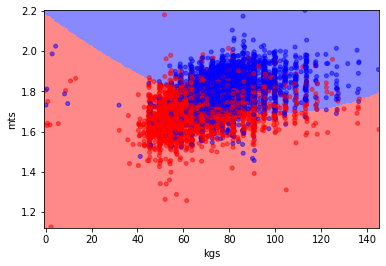

In [25]:
plot_classification(pipaPre, surfaceDF=gridPredictionLRPoly, prob=False)

Fin